# Lab 3 — recommender systems

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [3]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [11]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## 3.4 Basic Statistics

In [13]:
user_ratings = data.map(lambda d: (d['userId'], d['rating'])).collect()

In [14]:
ratings_per_user = data.map(lambda d: (d['userId'], d['rating'])).groupByKey().map(lambda d: len(d[1])).collect()

In [15]:
ratings_per_item = data.map(lambda d: (d['movieId'], d['rating'])).groupByKey().map(lambda d: len(d[1])).collect()

Text(0.5,1,'Histogram of how many items have how many ratings')

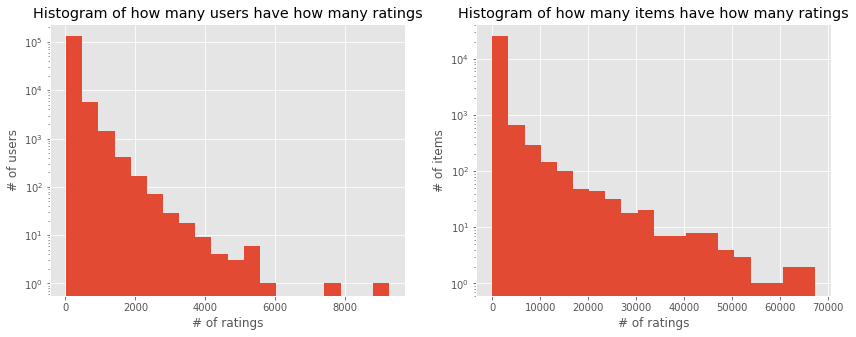

In [16]:
plt.figure(num=None, figsize=(14, 5))

plt.subplot(1,2,1)
plt.hist(ratings_per_user, bins=20, log=True)
plt.xlabel("# of ratings")
plt.ylabel("# of users")
plt.title("Histogram of how many users have how many ratings")

plt.subplot(1,2,2)
plt.hist(ratings_per_item, bins=20, log=True)
plt.xlabel("# of ratings")
plt.ylabel("# of items")
plt.title("Histogram of how many items have how many ratings")

The number of ratings are clearly not balanced uniformly, since many users/items have almost no ratings, while others have a lot.

In [12]:
with open('my-ratings.txt') as f:
    my_ratings = sc.parallelize([json.loads(line) for line in f.read().splitlines()])

In [13]:
data = data.union(my_ratings)

In [14]:
training = data.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating'])).persist()
validation = data.map(lambda x: (x['userId'], x['movieId'], x['rating'])).subtract(training).persist()

In [20]:
global_mean = training.map(lambda x: x[2]).reduce(lambda x, y: x + y)
global_mean /= training.count()

In [21]:
user_bias = training.map(lambda x: (x[0], x[2])).groupByKey().map(lambda x: (x[0], 0 if sum(x[1]) == 0 else sum(x[1])/len(x[1]) - global_mean))

In [22]:
u_b_local = dict(user_bias.collect())

In [23]:
item_bias = training.map(lambda x: (x[1], x[2] - u_b_local[x[0]])).groupByKey().map(lambda x: (x[0], 0 if sum(x[1]) == 0 else sum(x[1])/len(x[1]) - global_mean))

In [24]:
i_b_local = dict(item_bias.collect())

In [25]:
sq_err_per_user = validation.map(lambda x: (x[0], (x[2] - global_mean - u_b_local.get(x[0], 0) - i_b_local.get(x[1], 0))**2)).groupByKey()

In [26]:
mean_err = sq_err_per_user.map(lambda x: (sum(x[1])/len(x[1]), 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [27]:
mean_err[0]/mean_err[1]

0.8547799857909036

# 3.2.2 Matrix-factorization model
## Exercise 3.8 Regularization
The lower the rank, the less we use the information that is actually given to us. We risk overgeneralisation.<br>
The higher the rank, the more we assume that our data is representative for the real world. We risk overfitting.<br>
We start at the middle: 15

In [6]:
from pyspark.mllib.recommendation import ALS

In [6]:
rank = 15

#### Lambda 1e-10

In [28]:
model = ALS.train(training, rank, lambda_=1e-4)

In [31]:
predictions = model.predictAll(validation.map(lambda x: (x[0], x[1])))

In [38]:
error = predictions.map(lambda x: ((x[0], x[1]), x[2])).join(validation.map(lambda x: ((x[0], x[1]), x[2]))).map(lambda x: ((x[1][0] - x[1][1])**2, 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [39]:
error[0]/error[1]

0.8942589224731481

#### Lambda = 10

In [14]:
model2 = ALS.train(training, rank, lambda_=10.0)

In [15]:
predictions2 = model2.predictAll(validation.map(lambda x: (x[0], x[1])))

In [16]:
error2 = predictions2.map(lambda x: ((x[0], x[1]), x[2])).join(validation.map(lambda x: ((x[0], x[1]), x[2]))).map(lambda x: ((x[1][0] - x[1][1])**2, 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [17]:
error2[0]/error2[1]

13.537916768800555

#### Find optimal lambda

In [18]:
np.linspace(-5, 2, num=8)

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.])

In [19]:
errors = []
for l in np.linspace(-2, 0, num=4):
    print(l)
    l = 10 ** l
    model_l = ALS.train(training, rank, lambda_=l)
    predictions_l = model_l.predictAll(validation.map(lambda x: (x[0], x[1])))
    error_l = predictions_l.map(lambda x: ((x[0], x[1]), x[2])).join(validation.map(lambda x: ((x[0], x[1]), x[2]))).map(lambda x: ((x[1][0] - x[1][1])**2, 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    errors.append(error_l[0]/error_l[1])

-2.0
-1.33333333333
-0.666666666667
0.0


In [22]:
print(errors)
print("Best lamda approx.", 1e-1)

[0.6750010927871063, 0.6654452627619132, 0.7257885840091706, 1.7635819471162402]
Best lamda approx. 0.1


In [20]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [27]:
m = movies.map(lambda x: (x['movieId'], x['title'])).collectAsMap()

In [30]:
model = ALS.train(data.map(lambda x: (x['userId'], x['movieId'], x['rating'])), rank=15, lambda_=0.1)

In [39]:
for u, m2, r in model.recommendProducts(123, 10):
    print(m[m2])

Marihuana (1936)
No Distance Left to Run (2010)
Bill Hicks: Sane Man (1989)
Moth, The (Cma) (1980)
My Brother Tom (2001)
Infection (Kansen) (2004)
It's Love I'm After (1937)
I Belong (Som du ser meg) (2012)
Jim Jefferies: Alcoholocaust (2010)
Shoppen (2006) 


In [38]:
for u, m2, r in model.recommendProducts(138494, 10):
    print(m[m2])

Kevin Smith: Too Fat For 40 (2010)
Kevin Smith: Sold Out - A Threevening with Kevin Smith (2008)
Drew: The Man Behind the Poster (2013)
Afflicted, The (2010)
Craig Ferguson: A Wee Bit o' Revolution (2009)
Garfield's Halloween Adventure (1985)
No Distance Left to Run (2010)
Chameleon (Kaméleon) (2008)
Bill Burr: Why Do I Do This? (2008)
Bob Funk (2009)


In [24]:
import sparkpickle
import bokeh

ModuleNotFoundError: No module named 'sparkpickle'

In [25]:
selected_movies = pickle.load(open('selected-movies.pickle', 'rb'), encoding='utf-8')

In [9]:
selected_movies

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [15]:
model_vis = ALS.train(data.map(lambda x: (x['userId'], x['movieId'], x['rating'])), rank=2, lambda_=0.1)

In [29]:
selected_movie_ids = {m[0] for m in selected_movies}
selected_movie_features = model_vis.productFeatures().filter(lambda x: x[0] in selected_movie_ids).collect()

In [30]:
selected_movie_features

[(260, array('d', [0.8606478571891785, 2.5052008628845215])),
 (480, array('d', [1.1466630697250366, 2.026927947998047])),
 (780, array('d', [1.1983859539031982, 1.8026894330978394])),
 (1240, array('d', [0.9426621794700623, 2.2921133041381836])),
 (4700, array('d', [0.6622918248176575, 1.8986154794692993])),
 (43930, array('d', [0.510851263999939, 1.7157968282699585])),
 (2571, array('d', [0.8922098278999329, 2.4973855018615723])),
 (6132, array('d', [1.507636547088623, 1.376522183418274])),
 (5163, array('d', [1.8107975721359253, 1.327802300453186])),
 (48043, array('d', [0.9796392321586609, 2.134141206741333])),
 (54503, array('d', [0.6739794611930847, 2.333041191101074])),
 (2324, array('d', [0.6907341480255127, 2.587158679962158])),
 (6774, array('d', [1.5189406871795654, 1.908746600151062])),
 (55444, array('d', [1.064342737197876, 2.2989046573638916])),
 (805, array('d', [0.902935266494751, 2.156646251678467])),
 (4465, array('d', [0.6959421634674072, 2.333163022994995])),
 (723